# Play with pipeline

### Import

In [1]:
import os
PROJECT_PATH=os.getenv("IBENS_PROJECT_PATH") #Si bug: source ~/.bashrc
os.chdir(PROJECT_PATH)


import torch
from torch.utils.data import DataLoader, TensorDataset

#DataModule
from disdiff_adaptaters.data_module.shapes3d import Shapes3DDataModule
from disdiff_adaptaters.data_module.bloodmnist import BloodMNISTDataModule

#Module
from disdiff_adaptaters.arch.vae.encoder import Encoder

#utils
from disdiff_adaptaters.utils.utils import load_h5, collate_images, display, pca_latent
from disdiff_adaptaters.utils.const import Shapes3D, ChAda

#ext
from chada.backbones.vit.chada_vit import ChAdaViT

/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/op

## Load data

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(f"device is at {device}")

device is at cuda


### 3DShapes

In [3]:
if device == "cuda" :
    shapes = Shapes3DDataModule()
    shapes.prepare_data()
    shapes.setup(stage='fit')
    shapes_loader = shapes.train_dataloader()
else :
    images, labels = load_h5(Shapes3D.Path.H5)
    images = images[:100]
    labels = labels[:100]
    shapes_loader = DataLoader(TensorDataset(torch.tensor(images).permute(0,3,1,2), torch.tensor(labels)), batch_size=8, shuffle=True)

loading of tensors
tensors loaded.


In [4]:
for batch in shapes_loader :
    images, labels = batch
    print(images.shape)
    break

torch.Size([8, 3, 64, 64])


### BloodMNIST

In [19]:
blood = BloodMNISTDataModule()
blood.prepare_data()
blood.setup("fit")

torch.Size([3, 28, 28]) torch.Size([8, 1])


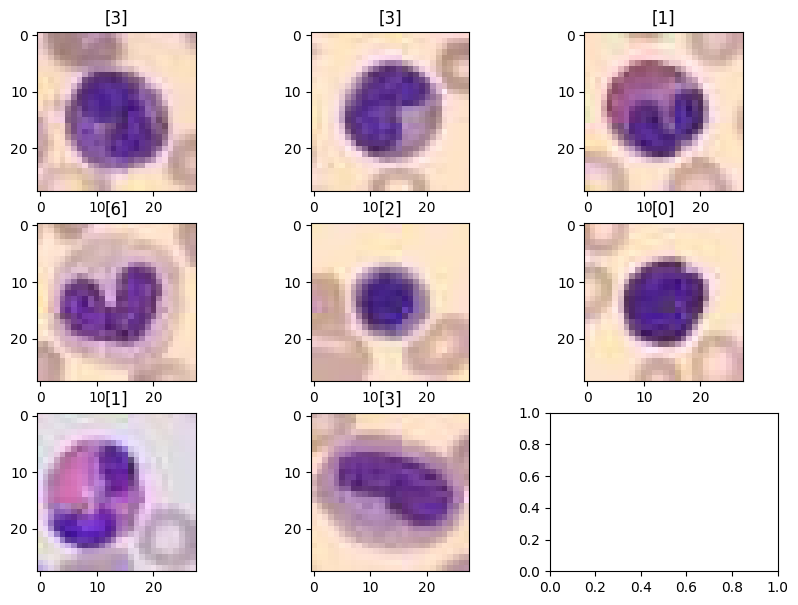

In [20]:
blood_loader = blood.train_dataloader()
for batch in blood_loader : 
    images, labels = batch
    print(images[0].shape, labels.shape)
    display(batch)
    break

## Encoder

### ChAda

In [5]:
# Params
PATCH_SIZE = 16
EMBED_DIM = 192
RETURN_ALL_TOKENS = False
MAX_NUMBER_CHANNELS = 10

In [6]:
model = ChAdaViT(
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    return_all_tokens=RETURN_ALL_TOKENS,
    max_number_channels=MAX_NUMBER_CHANNELS,
)

In [8]:
state = torch.load(ChAda.Path.WEIGHTS, map_location="cpu", weights_only=False)["state_dict"]
for k in list(state.keys()):
    if "encoder" in k:
        state[k.replace("encoder", "backbone")] = state[k]
    if "backbone" in k:
        state[k.replace("backbone.", "")] = state[k]
    del state[k]
model.load_state_dict(state, strict=False)
model.to("cpu")
model.eval()
model.mixed_channels = True

In [19]:
print(images.shape, labels.shape)

(480000, 64, 64, 3) (480000, 6)


In [ ]:
data = []
for batch in train_loader :
    images, labels = batch
    data_batch = []
    for image, label in zip(images, labels) :
        data_batch.append(images[i],)

    break

<class 'torch.Tensor'>


In [ ]:
for batch in train_loader : 
    #unpack batch
    images, labels = batch

    #Format batch in order to collate
    data = []
    for image, label in zip(images, labels) :
        data.append((image, label))
    #Collate images
    channels_list, labels_list, num_channels_list = collate_images(data)

    #Forward
    feats = model(channels_list, index=0, list_num_channel=num_channels_list)
    break

In [22]:
output

tensor([[ 1.3813, -0.8161,  1.0642, -1.8680,  1.3986,  1.1567,  0.6350, -0.0222,
          1.5576,  1.9850,  1.5999,  0.4893,  0.5862,  2.1450, -0.9456, -0.6991,
         -1.2963, -1.2560, -2.1907, -1.9560,  0.1671,  1.2622, -1.2758, -0.8391,
         -0.1157, -1.4872,  1.7005,  0.4986,  0.8209, -1.6139, -1.3855,  0.4419,
         -0.5098, -0.3220,  1.1783,  1.1320, -0.4826, -0.9351, -0.7490, -0.3625,
          0.9052, -0.0501,  0.2452, -0.2175,  0.1449,  0.4216,  0.0167,  0.5555,
          1.0213,  0.9465,  0.8716,  2.6457, -0.9982, -0.3541,  0.2795, -0.2061,
          0.2320, -0.7463, -0.5710, -0.3109,  1.9990,  2.0090,  0.1810,  1.7208,
         -0.3301, -1.1345,  0.5531, -0.2745, -0.2627, -1.6694, -1.1357, -0.2337,
          0.1739,  1.8382,  0.1912, -1.3422,  1.4479, -0.5516, -0.2163, -1.6908,
         -0.4320,  0.0068, -0.3481, -1.8300, -2.1380,  0.4883,  0.9845,  0.4305,
          1.6311, -0.5753,  1.4146, -0.2970,  0.0283,  0.8475, -0.3458,  0.7038,
          0.7426, -1.4992,  

### Variational Encoder

Let's display the PCA-latent space with VAE encoder

In [26]:
#Choose the right loader
loader = shapes_loader
for batch in loader :
    img_size = batch[0].shape[2]
    nb_channel = batch[0].shape[1]
    print(img_size, nb_channel)
    break

64 3


In [27]:
embed_dim = 192
encoder = Encoder(nb_channel, img_size, embed_dim)

encoder.eval()
embeds = []
labels = []

for batch in loader :
    image, label = batch
    print(image.shape)
    embed = encoder(image)

    embeds.append(embed)
    labels.append(label)
    break

torch.Size([1, 192, 8, 8])
torch.Size([8, 3, 64, 64])


In [35]:
mus = torch.cat([embed[0] for embed in embeds])
logvars = torch.cat([embed[1] for embed in embeds])
labels = torch.cat(labels)


TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [34]:
labels[:, 0].unsqueeze(1).shape

torch.Size([8, 1])

In [36]:
labels

tensor([[ 6,  4,  0,  2,  0,  9],
        [ 7,  0,  4,  7,  2,  1],
        [ 7,  4,  7,  1,  0,  5],
        [ 1,  2,  2,  2,  0,  9],
        [ 6,  7,  9,  6,  0, 14],
        [ 2,  4,  6,  0,  3,  1],
        [ 0,  8,  9,  6,  2,  6],
        [ 2,  7,  7,  6,  0,  5]])

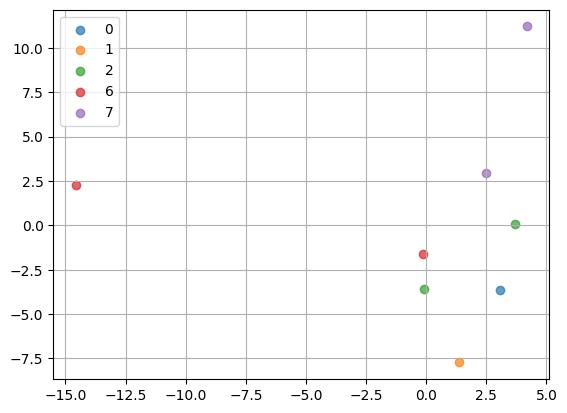

In [37]:
pca_latent((mus, logvars), labels[:, 0].unsqueeze(1))